In [ ]:
import requests
import pandas as pd
import json
import time
from concurrent.futures import ThreadPoolExecutor

# --- CONFIGURATION ---
TARGET_CATEGORIES = ["Education", "City Government"]
OUTPUT_FILE = "nyc_dataset_samples.csv"
BASE_URL = "https://api.us.socrata.com/api/catalog/v1"
SODA_BASE = "https://data.cityofnewyork.us/resource"

# --- 1. FETCH CATALOG METADATA ---
def fetch_catalog_metadata(categories, limit=3000):
    """
    Fetches the list of tabular datasets from the Socrata Discovery API.
    """
    all_datasets = []
    
    for cat in categories:
        print(f"Fetching catalog for category: '{cat}'...")
        params = {
            "domains": "data.cityofnewyork.us",
            "search_context": "data.cityofnewyork.us",
            "categories": cat,
            "only": "datasets",
            "limit": limit
        }
        
        try:
            resp = requests.get(BASE_URL, params=params)
            resp.raise_for_status()
            results = resp.json().get("results", [])
            
            for item in results:
                res = item.get("resource", {})
                
                # Filter: Must be dataset and have columns
                if res.get('type') == 'dataset' and res.get('columns_name'):
                    all_datasets.append({
                        "dataset_id": res.get("id"),
                        "name": res.get("name"),
                        "description": res.get("description", ""),
                        "category": cat,
                        "row_count_proxy": res.get('page_views', {}).get('page_views_total', 0),
                        # Save lists as JSON strings for CSV compatibility
                        "columns_name": json.dumps(res.get("columns_name", [])),
                        "columns_datatype": json.dumps(res.get("columns_datatype", [])),
                        # We try to get the system field names too, if available, to help matching later
                        "columns_field_name": json.dumps(res.get("columns_field_name", [])) 
                    })
        except Exception as e:
            print(f"  [!] Error fetching '{cat}': {e}")
            
    print(f"Total datasets found: {len(all_datasets)}")
    return pd.DataFrame(all_datasets).drop_duplicates("dataset_id")

# --- 2. FETCH NON-NULL SAMPLES (CORRECTED) ---
def fetch_dataset_samples(row):
    """
    Downloads 20 rows and extracts up to 3 non-null examples per column.
    FIX: Iterates through ACTUAL data keys, not expected metadata names.
    """
    dataset_id = row['dataset_id']
    
    try:
        # Fetch 20 rows to increase odds of finding data
        url = f"{SODA_BASE}/{dataset_id}.json?$limit=20"
        resp = requests.get(url, timeout=5)
        
        if resp.status_code != 200:
            return "{}"
            
        data = resp.json()
        if not data or not isinstance(data, list):
            return "{}"
            
        # --- THE FIX ---
        # 1. Identify all unique keys present in the returned data rows
        #    (This handles cases where metadata says "Zip Code" but API gives "zip_code")
        actual_keys = set().union(*(d.keys() for d in data))
        
        samples_map = {}
        
        for key in actual_keys:
            # 2. Extract non-null values for this key across all downloaded rows
            values = [str(r[key]) for r in data if r.get(key) is not None]
            
            # 3. Save unique top 3 (if any exist)
            unique_vals = list(set(values))[:3]
            if unique_vals:
                samples_map[key] = unique_vals
                
        return json.dumps(samples_map)
        
    except Exception:
        return "{}"

# --- MAIN EXECUTION ---

# 1. Get List
df = fetch_catalog_metadata(TARGET_CATEGORIES)

if not df.empty:
    print(f"\nStarting Parallel Sample Extraction for {len(df)} datasets...")
    
    # 2. Parallel Processing
    with ThreadPoolExecutor(max_workers=10) as executor:
        # Convert dataframe rows to a list of dicts for iteration
        rows = df.to_dict('records')
        # Map the fetch function to the rows
        results = list(executor.map(fetch_dataset_samples, rows))
        
    # 3. Attach Results
    df['sample_values'] = results
    
    # Check quality
    empty_samples = df[df['sample_values'] == "{}"].shape[0]
    print(f"\nExtraction complete.")
    print(f"Datasets with samples successfully retrieved: {len(df) - empty_samples}")
    print(f"Datasets with NO samples (Empty/Locked): {empty_samples}")

    # 4. Save
    df.to_csv(OUTPUT_FILE, index=False)
    
    print("\n" + "="*50)
    print(f"SUCCESS: Created '{OUTPUT_FILE}'")
    print("="*50)
else:
    print("No datasets found.")

Loading data from nyc_dataset_samples.csv...

TASK 2: DESCRIPTION QUALITY METRICS
Total Datasets Analyzed:               1260
1. Datasets with NO description:       38 (3.0%)
2. Description is identical to Name:   26 (2.1%)
--------------------------------------------------
Pareto Data Table:
  len_category  count  cum_sum    cum_perc
0         < 20     47       47    3.730159
1        20-50    132      179   14.206349
2       50-100    228      407   32.301587
3      100-300    321      728   57.777778
4      300-400    115      843   66.904762
5      400-500     78      921   73.095238
6      500-600     80     1001   79.444444
7      600-800    102     1103   87.539683
8     800-1000     51     1154   91.587302
9       > 1000    106     1260  100.000000
--------------------------------------------------


/tmp/ipykernel_3771/4181254515.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


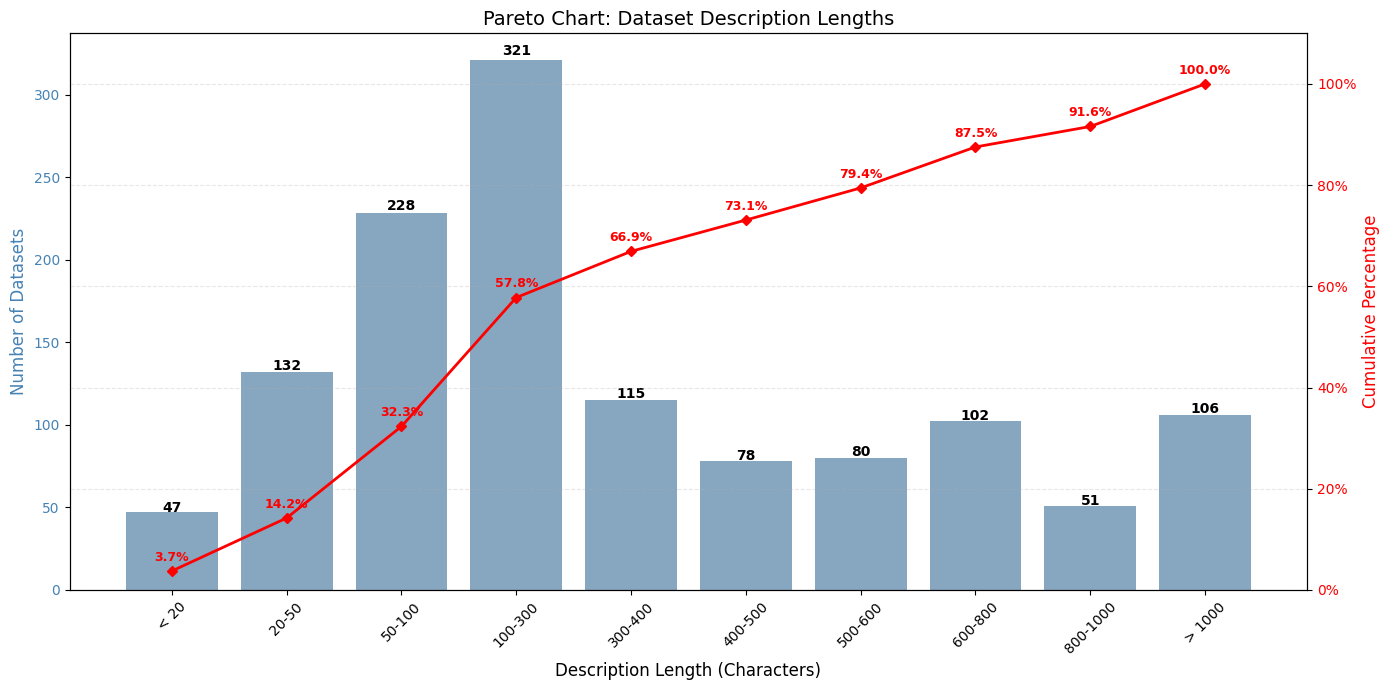

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# --- CONFIGURATION ---
INPUT_FILE = "nyc_dataset_samples.csv"

# --- MAIN ANALYSIS ---

# 1. Load Data
print(f"Loading data from {INPUT_FILE}...")
try:
    df = pd.read_csv(INPUT_FILE)
except FileNotFoundError:
    print("Error: File not found. Please run Task 1 first to generate the CSV.")
    exit()

# 2. Preprocessing
df['description'] = df['description'].fillna("").astype(str)
df['name'] = df['name'].fillna("").astype(str)
df['desc_len'] = df['description'].apply(len)

# 3. Create Granular Bins
bins = [0, 20, 50, 100, 300, 400, 500, 600, 800, 1000, 100000]
labels = [
    '< 20', 
    '20-50', 
    '50-100', 
    '100-300', 
    '300-400', 
    '400-500', 
    '500-600', 
    '600-800',
    '800-1000',
    '> 1000'
]

df['len_category'] = pd.cut(df['desc_len'], bins=bins, labels=labels, right=False)

# 4. Calculate Specific Quality Metrics (Requested)
empty_desc_count = len(df[df['desc_len'] == 0])
same_desc_count = len(df[df['description'].str.strip() == df['name'].str.strip()])

# 5. Calculate Statistics for Pareto
stats = df['len_category'].value_counts().reindex(labels)
stats_df = pd.DataFrame(stats).reset_index()
stats_df.columns = ['len_category', 'count']

# Calculate Cumulative Percentage
stats_df['cum_sum'] = stats_df['count'].cumsum()
stats_df['cum_perc'] = 100 * stats_df['cum_sum'] / stats_df['count'].sum()

# --- PRINT REPORT ---
print("\n" + "="*50)
print("TASK 2: DESCRIPTION QUALITY METRICS")
print("="*50)
print(f"Total Datasets Analyzed:               {len(df)}")
print(f"1. Datasets with NO description:       {empty_desc_count} ({empty_desc_count/len(df):.1%})")
print(f"2. Description is identical to Name:   {same_desc_count} ({same_desc_count/len(df):.1%})")
print("-" * 50)
print("Pareto Data Table:")
print(stats_df)
print("-" * 50)

# --- VISUALIZATION ---

fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar Chart (Primary Y-Axis)
sns.barplot(data=stats_df, x='len_category', y='count', color='steelblue', ax=ax1, alpha=0.7)
ax1.set_xlabel('Description Length (Characters)', fontsize=12)
ax1.set_ylabel('Number of Datasets', fontsize=12, color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Add count labels on bars
for i, v in enumerate(stats_df['count']):
    ax1.text(i, v + (v*0.01), str(v), color='black', ha='center', fontweight='bold')

# Pareto Line (Secondary Y-Axis)
ax2 = ax1.twinx()
ax2.plot(stats_df['len_category'], stats_df['cum_perc'], color='red', marker='D', ms=5, linewidth=2, label='Cumulative %')
ax2.set_ylabel('Cumulative Percentage', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylim(0, 110)

# Add percentage labels on the line points
for i, v in enumerate(stats_df['cum_perc']):
    ax2.text(i, v + 2, f"{v:.1f}%", color='red', ha='center', fontsize=9, fontweight='bold')

plt.title('Pareto Chart: Dataset Description Lengths', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Loading data from nyc_dataset_index.csv...
Calculating column counts...
Fetching actual row counts for 1260 datasets (this may take 1-2 minutes)...
Saved enriched data to 'nyc_dataset_index_enriched.csv'.

TASK 3: CORRELATION REPORT
Correlation Matrix (Spearman):
           desc_len  row_count  col_count
desc_len   1.000000   0.213518   0.031116
row_count  0.213518   1.000000   0.234244
col_count  0.031116   0.234244   1.000000
--------------------------------------------------
Correlation (Desc Length vs Rows):    0.214
Correlation (Desc Length vs Columns): 0.031

CONCLUSION: There is WEAK or NO correlation.
Larger, more complex datasets do NOT have better descriptions.
This justifies AutoDDG: We cannot rely on dataset size as a proxy for documentation quality.


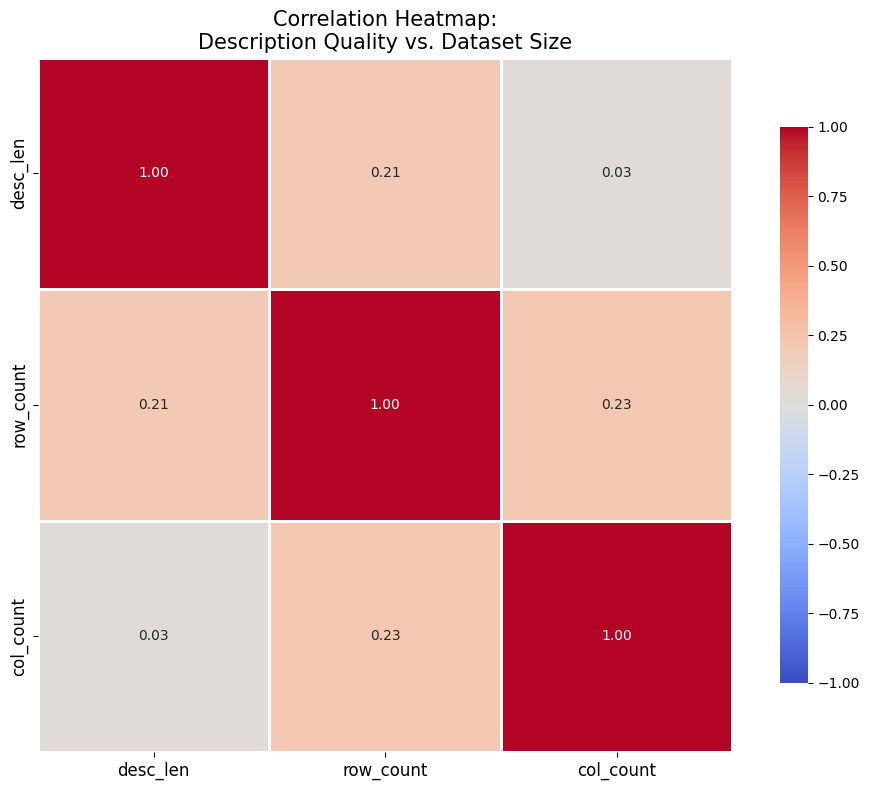

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import ast  # Safely evaluates string representations of lists
from concurrent.futures import ThreadPoolExecutor

# --- CONFIGURATION ---
INPUT_FILE = "nyc_dataset_samples.csv"
SODA_BASE = "https://data.cityofnewyork.us/resource"

# --- HELPER FUNCTIONS ---

def get_row_count(dataset_id):
    """
    Fetches the exact row count using the SODA API ($select=count(*)).
    """
    url = f"{SODA_BASE}/{dataset_id}.json?$select=count(*)"
    try:
        resp = requests.get(url, timeout=3)
        if resp.status_code == 200:
            return int(resp.json()[0].get('count', 0))
    except:
        return None
    return None

def fetch_row_counts_parallel(ids):
    """
    Fetches row counts in parallel to speed up the process.
    """
    print(f"Fetching actual row counts for {len(ids)} datasets (this may take 1-2 minutes)...")
    with ThreadPoolExecutor(max_workers=10) as executor:
        results = list(executor.map(get_row_count, ids))
    return results

# --- MAIN ANALYSIS ---

# 1. Load Data
print(f"Loading data from {INPUT_FILE}...")
try:
    df = pd.read_csv(INPUT_FILE)
except FileNotFoundError:
    print("Error: File not found. Please run Task 1 first.")
    exit()

# 2. Preprocessing & Calculation
# Description Length
df['description'] = df['description'].fillna("").astype(str)
df['desc_len'] = df['description'].apply(len)

# Column Count
# The CSV saves lists as strings like "['col1', 'col2']". We parse them to count items.
print("Calculating column counts...")
df['col_count'] = df['columns_name'].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else 0)

# Row Count (The Fetching Step)
# We only fetch if 'row_count' doesn't exist yet
if 'row_count' not in df.columns:
    df['row_count'] = fetch_row_counts_parallel(df['dataset_id'].tolist())
    # Save the enriched data so you don't have to fetch again next time
    df.to_csv("nyc_dataset_index_enriched.csv", index=False)
    print("Saved enriched data to 'nyc_dataset_index_enriched.csv'.")

# Filter out datasets where row count fetch failed (None)
df_clean = df.dropna(subset=['row_count']).copy()
df_clean['row_count'] = df_clean['row_count'].astype(int)

# 3. Correlation Matrix
# We select the three variables we care about
corr_data = df_clean[['desc_len', 'row_count', 'col_count']]
correlation_matrix = corr_data.corr(method='spearman') # Spearman is better for non-normal distributions (like this)

print("\n" + "="*50)
print("TASK 3: CORRELATION REPORT")
print("="*50)
print("Correlation Matrix (Spearman):")
print(correlation_matrix)
print("-" * 50)

# Interpret results textually
r_rows = correlation_matrix.loc['desc_len', 'row_count']
r_cols = correlation_matrix.loc['desc_len', 'col_count']

print(f"Correlation (Desc Length vs Rows):    {r_rows:.3f}")
print(f"Correlation (Desc Length vs Columns): {r_cols:.3f}")

if abs(r_rows) < 0.3 and abs(r_cols) < 0.3:
    print("\nCONCLUSION: There is WEAK or NO correlation.")
    print("Larger, more complex datasets do NOT have better descriptions.")
    print("This justifies AutoDDG: We cannot rely on dataset size as a proxy for documentation quality.")
else:
    print("\nCONCLUSION: There is some correlation between size and documentation.")

# --- VISUALIZATION ---

plt.figure(figsize=(10, 8))

# Draw the Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
            fmt='.2f', linewidths=1, linecolor='white', square=True, cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap:\nDescription Quality vs. Dataset Size', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
import requests
import json
import time
import os
import ast
from openai import OpenAI

# --- CONFIGURATION ---
OPENAI_API_KEY = ""  # <--- [IMPORTANT] Add Key
INPUT_FILE = "nyc_dataset_index.csv"  # The file from Task 1
OUTPUT_FILE = "semantic_gap_report.csv"
SODA_BASE = "https://data.cityofnewyork.us/resource"

# Safety limits
MAX_LLM_CALLS = 100  # How many columns to check before stopping?
CALLS_MADE = 0

# --- SETUP ---
if "PASTE" in OPENAI_API_KEY:
    print("⚠️ STOP: Please paste your OpenAI API Key first.")
    raise SystemExit("Missing API Key")

client = OpenAI(api_key=OPENAI_API_KEY)

# --- FUNCTIONS ---

def get_processed_ids():
    """ Returns a set of Dataset IDs we have already audited. """
    if not os.path.exists(OUTPUT_FILE):
        # Create file with headers if it doesn't exist
        pd.DataFrame(columns=[
            "dataset_id", "dataset_name", "column", "official_type", 
            "llm_detected_type", "reason", "samples"
        ]).to_csv(OUTPUT_FILE, index=False)
        return set()
    
    try:
        df = pd.read_csv(OUTPUT_FILE)
        return set(df['dataset_id'].unique())
    except:
        return set()

def fetch_live_metadata_and_samples(dataset_id):
    """
    Fetches official metadata (System Names + Types) AND 5 rows of data.
    """
    try:
        # 1. Fetch Metadata (to get System Names like 'zip_code')
        # Socrata 'views' endpoint gives us precise column metadata
        meta_url = f"https://data.cityofnewyork.us/api/views/{dataset_id}.json"
        meta_resp = requests.get(meta_url, timeout=3)
        if meta_resp.status_code != 200: return None
        
        meta = meta_resp.json()
        columns_meta = meta.get('columns', [])
        
        # 2. Fetch Data (5 rows)
        data_url = f"https://data.cityofnewyork.us/resource/{dataset_id}.json?$limit=5"
        data_resp = requests.get(data_url, timeout=3)
        rows = data_resp.json() if data_resp.status_code == 200 else []
        
        return columns_meta, rows
    except:
        return None

def ask_llm(col_name, col_type, samples):
    """ Asks GPT to classify the column. """
    sample_str = ", ".join([str(s)[:50] for s in samples][:5])
    
    prompt = (
        f"Column: '{col_name}'\nType: '{col_type}'\nSamples: [{sample_str}]\n\n"
        f"Task: The official type is generic (Text/Number). Does this semantically represent:\n"
        f"1. 'Location' (Zip, Address, Lat/Lon, Borough, BBL, NTA)?\n"
        f"2. 'Time' (Year, Date, Fiscal Period)?\n"
        f"3. 'Other'?\n"
        f"Return JSON: {{'semantic_type': 'Time'|'Location'|'Other', 'reason': 'brief reason'}}"
    )

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=60
        )
        content = response.choices[0].message.content
        if "{" in content: 
            content = "{" + content.split("{")[1].split("}")[0] + "}"
        return json.loads(content)
    except:
        return {"semantic_type": "Error"}

# --- MAIN EXECUTION ---

# 1. Load Index
print(f"Loading {INPUT_FILE}...")
try:
    df_index = pd.read_csv(INPUT_FILE)
except:
    print(f"Error: {INPUT_FILE} not found. Run Task 1."); exit()

# 2. Filter Processed
processed_ids = get_processed_ids()
remaining_df = df_index[~df_index['dataset_id'].isin(processed_ids)]

print(f"Total Datasets: {len(df_index)}")
print(f"Already Checked: {len(processed_ids)}")
print(f"Remaining to Audit: {len(remaining_df)}")

# 3. Stream Processing
print("\n=== STARTING LIVE AUDIT ===")
print("Press 'STOP' (Interrupt Kernel) at any time. Progress is saved instantly.")
print("-" * 90)
print(f"{'Dataset':<20} | {'Column':<20} | {'Type':<8} | {'Verdict'}")
print("-" * 90)

for idx, row in remaining_df.iterrows():
    if CALLS_MADE >= MAX_LLM_CALLS:
        print("\n🛑 Max LLM limit reached.")
        break
        
    did = row['dataset_id']
    dname = row['name'][:20]
    
    # A. Fetch Live Data
    result = fetch_live_metadata_and_samples(did)
    if not result:
        continue # Skip if API fails
        
    cols_meta, data_rows = result
    
    # B. Audit Columns
    dataset_findings = []
    
    for col_def in cols_meta:
        sys_name = col_def.get('fieldName') # e.g., 'zip_code'
        human_name = col_def.get('name')    # e.g., 'Zip Code'
        official_type = col_def.get('dataTypeName') # e.g., 'text'
        
        # Only audit generic types
        if official_type not in ['text', 'number', 'plain_text']:
            continue
            
        # Extract samples
        vals = [r.get(sys_name) for r in data_rows if r.get(sys_name) is not None]
        
        # Heuristic to save money: 
        # Only ask LLM if we have data AND the name "looks" suspicious
        if vals: 
            # Simple Regex Check
            is_suspicious = pd.Series([sys_name, human_name]).str.contains(
                r"year|date|time|loc|addres|zip|boro|school|building|lat|lon|grade|fiscal|period", 
                case=False, regex=True
            ).any()
            
            if is_suspicious:
                # LLM CALL
                res = ask_llm(human_name, official_type, vals)
                CALLS_MADE += 1
                
                detected = res.get('semantic_type', 'Other')
                
                # Print
                icon = "🚨" if detected in ['Time', 'Location'] else ".."
                print(f"{dname:<20} | {human_name[:20]:<20} | {official_type:<8} | {icon} {detected}", flush=True)
                
                # Store if it's a finding OR just to mark as processed
                if detected in ['Time', 'Location']:
                    dataset_findings.append({
                        "dataset_id": did,
                        "dataset_name": row['name'],
                        "column": human_name,
                        "official_type": official_type,
                        "llm_detected_type": detected,
                        "reason": res.get('reason'),
                        "samples": str(vals[:3])
                    })
    
    # C. Save to Disk immediately
    if dataset_findings:
        pd.DataFrame(dataset_findings).to_csv(OUTPUT_FILE, mode='a', header=False, index=False)
    else:
        # If no findings, we still want to mark ID as processed so we don't check again
        # We append a dummy row with "Checked" status (optional, or just rely on 'remaining_df' logic next run)
        # For this script, we just proceed.
        pass
        
    time.sleep(0.5)

print("\n" + "="*50)
print(f"Audit Finished. {CALLS_MADE} columns checked.")
print(f"Results saved to: {OUTPUT_FILE}")

Loading nyc_dataset_index.csv...
Total Datasets: 1260
Already Checked: 0
Remaining to Audit: 1260

=== STARTING LIVE AUDIT ===
Press 'STOP' (Interrupt Kernel) at any time. Progress is saved instantly.
------------------------------------------------------------------------------------------
Dataset              | Column               | Type     | Verdict
------------------------------------------------------------------------------------------
2012 SAT Results     | SCHOOL NAME          | text     | .. Error
2017 DOE High School | school_name          | text     | .. Other
2017 DOE High School | boro                 | text     | 🚨 Location
2017 DOE High School | school_10th_seats    | number   | .. Error
2017 DOE High School | building_code        | text     | .. Other
2017 DOE High School | location             | text     | 🚨 Location
2017 DOE High School | school_email         | text     | .. Other
2017 DOE High School | grades2018           | text     | .. Other
2017 DOE High School